`enter code here`XGBoost_auc_0.99831

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score
from sklearn import metrics


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot')
import seaborn as sns
%matplotlib inline


from scipy.stats import skew, boxcox
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Checking data
csvfile_path = '../input/PS_20174392719_1491204439457_log.csv'
raw_data = pd.read_csv(csvfile_path)
print ("raw data shape:", raw_data.shape)
print(raw_data.head())
print(raw_data.describe())
print(raw_data.info())

raw data shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  

In [3]:
# check the missing values
raw_data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


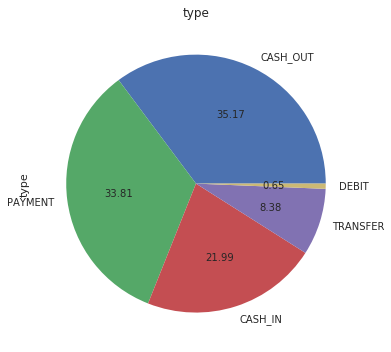

In [4]:
# exploratory the colum of 'type'
print(raw_data['type'].value_counts())
raw_data['type'].value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('type')
plt.tight_layout()

In [5]:
pd.crosstab(raw_data['type'], raw_data['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [6]:
pd.crosstab(raw_data['type'], raw_data['isFlaggedFraud'])

isFlaggedFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,0
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,532893,16


In [7]:
raw_data[['nameOrig', 'nameDest']].describe()

,nameOrig,nameDest
count,6362620,6362620
unique,6353307,2722362
top,C1784010646,C1286084959
freq,3,113


In [8]:
data_used = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
data_used.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

data_used = data_used.reset_index(drop=True)

type_encoder = preprocessing.LabelEncoder()
type_category = type_encoder.fit_transform(data_used['type'].values)
data_used['type_code'] = type_category

print ("data_used shape:", data_used.shape)
print(data_used.head())
print(data_used.info())

data_used shape: (2770409, 8)
       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   
3  TRANSFER  215310.30          705.0             0.0         22425.0   
4  TRANSFER  311685.89        10835.0             0.0          6267.0   

   newbalanceDest  isFraud  type_code  
0            0.00        1          1  
1            0.00        1          0  
2        51513.44        0          0  
3            0.00        0          1  
4      2719172.89        0          1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2770409 entries, 0 to 2770408
Data columns (total 8 columns):
type              object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64


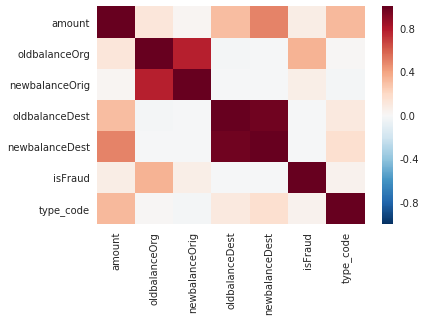

In [9]:
sns.heatmap(data_used.corr())

0    2762196
1       8213
Name: isFraud, dtype: int64


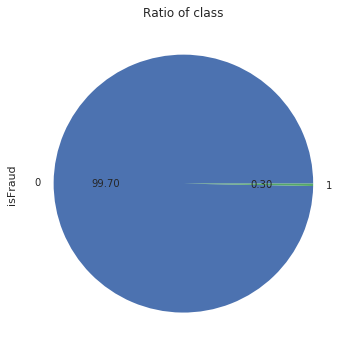

In [10]:
# check the balance of the data_used
print(data_used['isFraud'].value_counts())

data_used.isFraud.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Ratio of class')
plt.tight_layout()

In [11]:
# under sample
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                 'oldbalanceDest', 'newbalanceDest', 'type_code']
number_records_fraud = len(data_used[data_used['isFraud'] == 1])

#　indices of fraud_indices
fraud_indices = data_used[data_used['isFraud'] == 1].index.values

#indices of the normal records
nonfraud_indices = data_used[data_used['isFraud'] == 0].index

random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

under_sample_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sample_data = data_used.iloc[under_sample_indices, :]
                          
print(under_sample_data[feature_names].head())
X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values
print("--------------------------------------------------------------------------")

print("Ratio of nomal: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("Ratio of fraud: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("Number of data for model: ", len(under_sample_data))


      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0      181.0          181.0             0.0             0.0             0.0   
1      181.0          181.0             0.0         21182.0             0.0   
123   2806.0         2806.0             0.0             0.0             0.0   
124   2806.0         2806.0             0.0         26202.0             0.0   
192  20128.0        20128.0             0.0             0.0             0.0   

     type_code  
0            1  
1            0  
123          1  
124          0  
192          1  
--------------------------------------------------------------------------
Ratio of nomal:  0.5
Ratio of fraud:  0.5
Number of data for model:  16426


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=100)

Baseline model: losgistic(auc = 0.97576)

auc: 0.978174222732


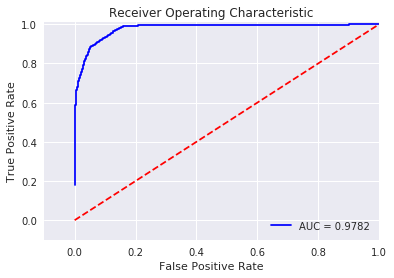

coef_: [[ -9.94911552e-07   2.28116790e-05  -2.22697571e-05   1.12485955e-05
   -1.12944154e-05   1.04283399e+00]]


In [13]:
from sklearn.linear_model import LogisticRegressionCV
alpha = np.logspace(-2, 2, 20)
lr_model_cv = LogisticRegressionCV(Cs=alpha, penalty='l1', solver='liblinear', cv=5)
lr_model_cv.fit(X_train, y_train)

y_pred_score_cv = lr_model_cv.predict_proba(X_test)
# print('y_pred_score_cv:')
# print(y_pred_score_cv)

fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, y_pred_score_cv[:, 1])
roc_auc_cv = auc(fpr_cv,tpr_cv)
print('auc:', roc_auc_cv)
# 绘制ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_cv, tpr_cv, 'b',label='AUC = %0.4f'% roc_auc_cv)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('coef_:', lr_model_cv.coef_)

XGBoost: auc = 0.99831

auc_test: 0.998402634327
auc_train: 0.999999878972
best_params {'max_depth': 12, 'n_estimators': 200}


test classification report: 
              precision    recall  f1-score   support

          0       1.00      0.99      0.99      2490
          1       0.98      1.00      0.99      2438

avg / total       0.99      0.99      0.99      4928

train classification report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00      5723
          1       1.00      1.00      1.00      5775

avg / total       1.00      1.00      1.00     11498



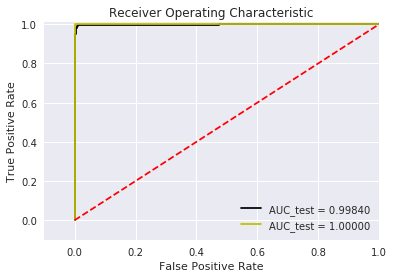

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [80, 100, 120, 160, 200], 'max_depth': range(2, 16, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)


In [14]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_test0b = {    
    'n_estimators':[80, 100, 120,160,200],
    'max_depth':range(2,16,2),
#     'min_child_weight':range(1,8,2),
#     'gamma':[0,0.1,0.2,0.3,0.4,0.5,0.6]，
#     'subsample':[i/100.0 for i in range(75,90,5)],
#     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
    
#     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb_cv0b = GridSearchCV(estimator=xgb.XGBClassifier(learning_rate =0.1,
                                                   n_estimators=100, 
                                                   max_depth=6,
                                                   min_child_weight=1,  
                                                   gamma=0, 
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic', 
                                                   nthread=4,
                                                   scale_pos_weight=1, 
                                                   seed=27),
                       param_grid = param_test0b,
                       scoring='roc_auc',
                       n_jobs=4,
                       iid=False, 
                       cv=5
                       )

xgb_cv0b.fit(X_train, y_train)
test_est_xgb_cv = xgb_cv0b.predict(X_test)
test_est_p_xgb_cv = xgb_cv0b.predict_proba(X_test)[:,1]

train_est_xgb_cv = xgb_cv0b.predict(X_train)
train_est_p_xgb_cv = xgb_cv0b.predict_proba(X_train)[:,1]

test_est_xgb_cv = xgb_cv0b.predict(X_test)
test_est_p_xgb_cv = xgb_cv0b.predict_proba(X_test)[:,1]

train_est_xgb_cv = xgb_cv0b.predict(X_train)
train_est_p_xgb_cv = xgb_cv0b.predict_proba(X_train)[:,1]

fpr_test_xgb_cv, tpr_test_xgb_cv, th_test_xgb_cv = metrics.roc_curve(y_test, test_est_p_xgb_cv)
test_roc_auc_xgb_cv = auc(fpr_test_xgb_cv,tpr_test_xgb_cv)

fpr_train_xgb_cv, tpr_train_xgb_cv, th_train_xgb_cv = metrics.roc_curve(y_train, train_est_p_xgb_cv)
train_roc_auc_xgb_cv = auc(fpr_train_xgb_cv,tpr_train_xgb_cv)
print('auc_test:', test_roc_auc_xgb_cv)
print('auc_train:', train_roc_auc_xgb_cv)
print('best_params',xgb_cv0b.best_params_)
print('\n')
print('test classification report: \n',metrics.classification_report(y_test, test_est_xgb_cv))
print('train classification report: \n',metrics.classification_report(y_train, train_est_xgb_cv))

# 绘制ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_test_xgb_cv, tpr_test_xgb_cv, color="k",label='AUC_test = %0.5f'% test_roc_auc_xgb_cv)
plt.plot(fpr_train_xgb_cv, tpr_train_xgb_cv, color="y",label='AUC_test = %0.5f'% train_roc_auc_xgb_cv)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(xgb_cv0b)